In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

from torch import nn
from torch.nn import functional as F

import sys 
import getpass

sys.path.append('../')
from Miniproject_2.model import *
torch.set_grad_enabled(True);

In [2]:
def nn_init_weights(model):
    if isinstance(model,nn.Conv2d) or isinstance(model,nn.ConvTranspose2d):
        xavier_normal_(model.weight.data)

In [3]:
def train_nn(model, criterion, train_input, train_target, mini_batch_size, nb_epochs, eta=0.1, optimize=False):
    if optimize: optimizer = torch.optim.SGD(model.parameters(), lr=eta, )
    
    for e in range(nb_epochs):
        for inputs, targets in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(inputs)
            loss = criterion(output, targets)

            model.zero_grad()
            loss.backward()
            
            if optimize:
                optimizer.step()
            else:
                with torch.no_grad():
                    for p in model.parameters(): p -= eta * p.grad
        print("\rCompleted: %d/%d"%(e+1,nb_epochs), end=' ')
    return 

In [4]:
stride = ks = 2

conv1 = nn.Conv2d(in_channels=3, out_channels=32,  kernel_size=ks, stride=stride, bias=False)
conv2 = nn.Conv2d(in_channels=32, out_channels=32,  kernel_size=ks, stride=stride, bias=False)

tconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=32,  kernel_size=ks,\
                            stride=stride, padding=0, dilation=1, bias=False)
tconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=3,  kernel_size=ks,\
                            stride=stride, padding=0, dilation=1, bias=False)

relu = nn.ReLU()
sigmoid = nn.Sigmoid()

Net = nn.Sequential(conv1, relu, conv2, relu, tconv1, relu, tconv2, sigmoid)
Net.apply(nn_init_weights);

In [5]:
train_in, train_tg = torch.load('../train_data.pkl')
train_in = train_in[:10000].float()/255.
train_tg = train_tg[:10000].float()/255.

criterion = nn.MSELoss()
bs = 16
ne = 5

In [6]:
#auto_train_nn(Net, criterion, train_in, train_tg, bs, ne)
train_nn(Net, criterion, train_in, train_tg, bs, ne, optimize=False)

Completed: 5/5 

In [7]:
val_in, val_tg = torch.load('../val_data.pkl')
val_in = val_in.float()/255.
val_tg = val_tg.float()/255.

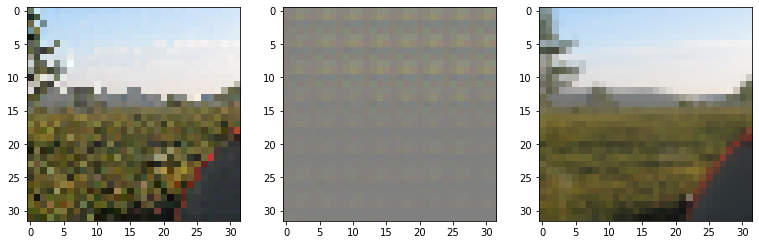

In [8]:
idx = 161
fig, ax = plt.subplots(1,3,figsize=(13,10))

with torch.no_grad():
    ax[0].imshow(val_in[idx].permute(1,2,0))
    ax[1].imshow(Net(val_in)[idx].permute(1,2,0))
    ax[2].imshow(val_tg[idx].permute(1,2,0))

In [9]:
def train_mynn(model, train_input, train_target, mini_batch_size, nb_epochs, eta=0.1):
    criterion = MSE()
    for e in range(nb_epochs):
        for inputs, targets in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(inputs)
            loss = criterion(output, targets)

            model.zero_grad()
            model.backward(criterion.backward())
            
            for p in model.parameters(): 
                if p : p[0] -= eta * p[1]
        print("\rCompleted: %d/%d"%(e+1,nb_epochs), end=' ')
    return 

In [10]:
my_conv1 = Conv2d(in_channels=3, out_channels=32, stride=stride,  kernel_size=ks)
my_conv2 = Conv2d(in_channels=32, out_channels=32, stride=stride,  kernel_size=ks)


my_tconv1 = TransposeConv2d(in_channels=32, out_channels=32,  kernel_size=ks, stride=stride, padding=0, dilation=1)
my_tconv2 = TransposeConv2d(in_channels=32, out_channels=3,  kernel_size=ks, stride=stride, padding=0, dilation=1)

my_relu = ReLU()
my_sigmoid = Sigmoid()

my_Net = Sequential(my_conv1, my_relu, my_conv2, my_relu, my_tconv1, my_relu, my_tconv2, my_sigmoid, initialize=True)


In [12]:
train_mynn(my_Net, train_in, train_tg, bs, ne)

Completed: 5/5 

In [ ]:
mod = Model()
mod.train(train_in, train_tg, 5)

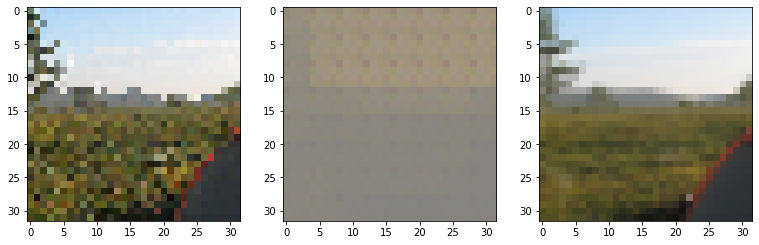

In [14]:
idx = 161
fig, ax = plt.subplots(1,3,figsize=(13,10))

with torch.no_grad():
    ax[0].imshow(val_in[idx].permute(1,2,0))
    ax[1].imshow(my_Net(val_in)[idx].permute(1,2,0))
    ax[2].imshow(val_tg[idx].permute(1,2,0))

In [ ]:
# Miniproject 2

from email import generator
import torch, math
from collections import OrderedDict
from typing import Dict, Optional
from torch.nn.functional import fold, unfold
import copy

torch.set_grad_enabled(False)



def _calculate_fan_in_and_fan_out(tensor):
    dimensions = tensor.dim()
    assert dimensions >= 2

    num_input_fmaps  = tensor.size(1)
    num_output_fmaps = tensor.size(0)
    receptive_field_size = 1
    
    if tensor.dim() > 2:
        for s in tensor.shape[2:]:
            receptive_field_size *= s
    
    fan_in  = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size

    return fan_in, fan_out


def xavier_normal_(tensor, gain=1):
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    std = gain * math.sqrt(2.0 / (fan_in + fan_out))
    return tensor.normal_(0, std)


def _init_weights(model):
    if isinstance(model, Conv2d) or isinstance(model, TransposeConv2d):
        xavier_normal_(model.weight) #model.weight.normal_(0,0.5,generator=torch.manual_seed(0))




def conv2d(input, weight, stride=1, padding=0, dilation=1):
    N, _, h_in, w_in = input.shape
    out_channels, in_channels, kernel_size = weight.shape[:-1]
    
    assert input.shape[1] == in_channels
    
    h_out = int((h_in + 2*padding - dilation*(kernel_size-1)-1)/stride+1)
    w_out = int((w_in + 2*padding - dilation*(kernel_size-1)-1)/stride+1)

    x = unfold(input, kernel_size=kernel_size, padding=padding, dilation=dilation, stride=stride)
    cΠks, L = x.shape[1], x.shape[2]
    
    x = torch.transpose(x, 1, 2).reshape(-1, cΠks)
    weight_flat = weight.reshape(out_channels, cΠks)
    
    x = x @ weight_flat.t()
    x = x.reshape(N, L, out_channels).transpose_(1, 2)
    x = fold(x, output_size=[h_out, w_out], kernel_size=1, padding=0, dilation=dilation, stride=1)
    return x


def conv_transpose2d(input, weight, stride=1, padding=0, dilation=1):
    N, _, h_in, w_in = input.shape
    in_channels, out_channels, kernel_size = weight.shape[:-1]
    
    eff_input = augment(input, nzeros=stride-1, padding=kernel_size-1-padding)
    return  conv2d(eff_input, weight.flip(2,3).transpose(0,1), stride=1, padding=0, dilation=1) 


def augment(input, nzeros, padding=0):
    shape = input.shape
    nold  = shape[-1]
    nnew  = nold + (nold-1)*nzeros
    
    new = torch.zeros(*shape[:2], nnew, nnew)
    new[:,:,::(nzeros+1),::(nzeros+1)] = input
                
    if padding: new = unfold(new,1, padding=padding).reshape(*new.shape[:2],*[new.shape[-1]+2*padding]*2)
    return new


def conv_backward(input, dL_dy, weight, stride=1, padding=0, dilation=1):
    out_channels, in_channels, kernel_size = weight.shape[:-1]
    dL_dx = conv_transpose2d(dL_dy, weight, stride=stride, padding=padding, dilation=dilation)

    ignored = int(input.shape[-1]-dL_dx.shape[-1])
    if ignored:
        dL_dx = unfold(dL_dx, 1, padding=ignored).reshape(*dL_dx.shape[:2],*[dL_dx.shape[-1]+2*ignored]*2)
        dL_dx = dL_dx[:,:,ignored:, ignored:]


    dL_df = torch.zeros_like(weight.transpose(0,1))
    dL_dy_aug = augment(dL_dy, nzeros=stride-1, padding=0)

    x = input if not ignored else input[:,:,:-ignored, :-ignored]
    for mu in range(x.shape[0]):
        for alpha in range(in_channels):
            dLdy = dL_dy_aug[mu].view(1, out_channels,*dL_dy_aug.shape[2:]).transpose(0,1)
            xx   = x[mu,alpha].view(1,1,*x.shape[2:])
            dL_df[alpha] += conv2d(xx, dLdy)[0]

    dL_df.transpose_(0,1)
    return dL_dx, dL_df




class Module(object):
    def __init__(self):
        self.parameters = []
        self.input = [] 
        pass
    def forward (self) :
        raise NotImplementedError
    def backward (self, input):
        raise NotImplementedError
    def param (self) :
        return self.parameters



class ReLU(Module):
    def __init__(self):
        super().__init__()
        return 

    def forward(self,input):
        self.input.append(input)
        return torch.relu(input)
    
    __call__ = forward

    def backward(self,dL_dy):
        return dL_dy * (self.input.pop() > 0)



class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        return 

    def forward(self,input):
        self.input.append(input)
        return torch.sigmoid(input)
    
    __call__ = forward

    def backward(self, dL_dy):
        x = self.input.pop()
        dsigma_dx = torch.sigmoid(x)*(1.-torch.sigmoid(x))
        return dL_dy*dsigma_dx



class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, initialize=True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.stride   = stride
        self.padding  = padding
        self.dilation = dilation

        self.weight   = torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
        if initialize: _init_weights(self.weight)

        self.parameters = [self.weight, None]
        
    def forward(self, input):
        self.input.append(input)
        return conv2d(input, self.weight, stride=self.stride, padding=self.padding, dilation=self.dilation)
    
    __call__ = forward
    
    def backward(self, dL_dy):
        dL_dx, dL_df = conv_backward(self.input.pop(), dL_dy, self.weight, stride=self.stride, padding=self.padding, dilation=self.dilation)
        self.parameters[1] = dL_df
        return dL_dx
    
    
    
class TransposeConv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, initialize=True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.stride   = stride
        self.padding  = padding
        self.dilation = dilation

        self.weight   = torch.Tensor(in_channels, out_channels, kernel_size, kernel_size)
        if initialize: _init_weights(self.weight)

        self.parameters = [self.weight, None]
        
    def forward(self, input):
        self.input.append(input)
        return conv_transpose2d(input, self.weight, stride=self.stride, padding=self.padding, dilation=self.dilation)
    
    __call__ = forward
    
    def backward(self, dL_dy):
        p = self.kernel_size-1-self.padding
        z = self.stride-1
        
        eff_input  = augment(self.input.pop(), nzeros=z, padding=p)
        eff_weight = self.weight.flip(2,3).transpose(0,1)
        dL_dx, dL_df = conv_backward(eff_input, dL_dy, eff_weight, stride=1, padding=0, dilation=1)
        
        dL_df = dL_df.flip(2,3).transpose(0,1)
        self.parameters[1] = dL_df
        return dL_dx[:,:,p:-p:z+1, p:-p:z+1]



class MSE(Module):
    def __init__(self):
        super().__init__()
        self.input : torch.Tensor
        self.reference : torch.Tensor
    
    def forward(self,input,reference):
        self.input     = input
        self.reference = reference
        output         = ((input-reference)**2).sum()/input.size().numel()
        return output.item()

    __call__ = forward

    def backward(self):
        return 2*(self.input - self.reference)/self.input.size().numel()



class Sequential():
    def __init__(self, *args, initialize=True):
        self._modules: Dict[str, Optional['Module']] = OrderedDict()

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

        if initialize: self.initialize()

    def __str__(self):
        to_print = '\n'
        for key,val in self._modules.items():
            to_print += key + '\n'
        return to_print

    def add_module(self, name, module):
        self._modules[name] = module

    def initialize(self):
        for module in self._modules.values():
            _init_weights(module)
        return 

    def parameters(self):
        for module in self._modules.values():
            yield module.parameters
    
    def zero_grad(self):
        for module in self._modules.values():
            if module.parameters:
                module.parameters[1] = 0

    def forward(self, input):
        for module in self._modules.values():
            input = module(input)
        return input

    __call__ = forward

    def backward(self,x):
        for module in reversed(self._modules.values()):
            x = module.backward(x)
           







#===========================================================
#                          MODEL                                            
#===========================================================  


class Model():

    def __init__(self) -> None:

        self.criterion  = MSE()
        self.optimizer  = None

        self.stride     = 2
        self.kernel_size     = 2
        self.features   = 5

        self.loss = MSE()

        self.eta        = 0.1
        self.gamma      = 0.5
        self.params_old   = None
        self.batch_size = 32

        

        conv1 = Conv2d(3,self.features, self.kernel_size, stride=self.stride, padding=0, dilation=1)
        # conv1.weight=f
        relu1 = ReLU()
        conv2 = Conv2d(5,self.features,self.kernel_size, stride=self.stride, padding=0, dilation=1)
        relu2 = ReLU()
        tconv3 = TransposeConv2d(5,self.features, self.kernel_size, stride=self.stride, padding=0, dilation=1)
        relu3 = ReLU()
        tconv4 = TransposeConv2d(self.features,3, self.kernel_size, stride=self.stride, padding=0, dilation=1)
        sig4 = Sigmoid() 

        self.net = Sequential(conv1,  
                        relu1,  
                        conv2, 
                        relu2, 
                        tconv3,
                        relu3, 
                        tconv4,
                        sig4
                        )

    def predict(self,x) -> torch.Tensor:
        return self.net.forward(x)

    def train(self, train_input, train_target, num_epochs):
        for epoch in range(num_epochs):
            for x, trg in zip(train_input.split(self.batch_size), train_target.split(self.batch_size)):
                out = self.net(x)
                _ = self.loss(out, trg)

                self.net.zero_grad()
                self.net.backward(self.loss.backward())
                self.SGD()


        pass

    def SGD(self):
        for idx, p in enumerate(self.net.parameters()):
            if p:
                if self.params_old is not None:
                    grad = self.gamma * self.params_old[idx][1] + self.eta * p[1] 
                else:
                    grad = self.eta * p[1]
                p[0] = p[0] - grad
        self.params_old = copy.deepcopy(list(self.net.parameters()))
                

